In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys
import matplotlib.pyplot as plt
import numpy as np
import helper
import simulation

# Generate some random images
#input_images, target_masks = simulation.generate_random_data(256, 256, count=2)

_channels = 2
_offset = 0 # 0 = next <_channels>
            # 720 = 24 hours
# _dataset = "mrms"
_dataset = "hrrr"
"""for x in [input_images, target_masks]:
    print(x.shape)
    print(x.min(), x.max())"""

# Change channel-order and make 3 channels for matplot
#input_images_rgb = [x.astype(np.uint8) for x in input_images]

# Map each channel (i.e. class) to each color
#target_masks_rgb = [helper.masks_to_colorimg(x) for x in target_masks]

# Left: Input image, Right: Target mask
#helper.plot_side_by_side([input_images_rgb, target_masks_rgb])

'for x in [input_images, target_masks]:\n    print(x.shape)\n    print(x.min(), x.max())'

In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import cv2
import datetime

class SimDataset(Dataset):
    def __init__(self, count, transform=None):
        self.numImageInput = _channels*2-1
        self.count = count
        #self.input_images, self.target_masks = simulation.generate_random_data(256, 256, count=count)      
        #self.input_images, self.target_masks = self.get_images(3,3, count)
        if (_dataset == "mrms"):
            self.get_images(3,3, count)
        elif (_dataset == "hrrr"):
            self.get_images(3,3, count)
        
        #print(self.target_masks)
        #self.target_masks = np.reshape(self.target_masks, (count, 255, 255))
        print("Input: ", self.input_images.shape)
        print("Masks: ", self.target_masks.shape)
        self.transform = transform
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):        
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        #print("Image: "+str(image.shape))
        if self.transform:
            image = self.transform(image)

        return [image, mask]

    def getNextImageName(self, path):
        dateStartIndex = path.find("_")+1
        year = path[dateStartIndex:dateStartIndex+4]
        month = path[dateStartIndex+4:dateStartIndex+6]
        day = path[dateStartIndex+6:dateStartIndex+8]

        timeStartIndex = path.find("-")+1
        hour=path[timeStartIndex:timeStartIndex+2]
        minute=path[timeStartIndex+2:timeStartIndex+4]

        inputImageTime = datetime.datetime(int(year), int(month), int(day), int(hour), int(minute))
        if (_dataset == "mrms"):
            timeInterval = datetime.timedelta(minutes=2)
        elif (_dataset == "hrrr"):
            timeInterval = datetime.timedelta(hours=1)
        outputImageTime = inputImageTime+timeInterval
        outputImageTime.strftime("%Y%m%d-%H%M00")
        outputPath = "CONUS_" + str(outputImageTime.strftime("%Y%m%d-%H%M")) +path[timeStartIndex+4:]
        return(outputPath)

    def checkImages(self, path, images, imageIndex):
        if not (os.path.exists(os.path.join(path, self.getNextImageName(images[imageIndex])))):
            #print(os.path.join(path, self.getNextImageName(images[imageIndex])))
            return False
        else:
            return True

    def get_images(self, X,Y, count):
        count+=self.numImageInput
        
        if (_dataset == "mrms"):
            path = "/home/ubuntuos/WeatherUNet/WeatherTiles/scripts/output/cropped/" + "("+str(X)+", " + str(Y) +")/"
            files= os.listdir(path)
            images = []
            for file in files:
                if file.endswith("("+str(X)+", "+str(Y)+").png"):
                    images.append(file)
            images.sort()
            rand_int = np.random.choice(len(images)-self.numImageInput-_offset, size=count-self.numImageInput, replace=False)

        elif (_dataset == "hrrr"):
            inputPath = "/home/ubuntuos/WeatherUNet/WeatherTiles/scripts/output/cropped_hrrr/f01" + "/("+str(X)+", " + str(Y) +")/"
            maskPath = "/home/ubuntuos/WeatherUNet/WeatherTiles/scripts/output/cropped_hrrr/f00" + "/("+str(X)+", " + str(Y) +")/"
            input_files=os.listdir(inputPath)
            mask_files=(os.listdir(maskPath))
            imagesInput=[]
            imagesMask=[]
            for file in input_files:
                if file.endswith("("+str(X)+", "+str(Y)+").png"):
                    imagesInput.append(file)
            for file in mask_files:
                if file.endswith("("+str(X)+", "+str(Y)+").png"):
                    imagesMask.append(file)
            imagesInput.sort()
            imagesMask.sort()
            rand_int = np.random.choice(min(len(imagesInput), len(imagesMask))-_channels-_offset, size=count-self.numImageInput, replace=False)
        
        image_output = []
        image_temp = []

        
        print("Reading Images...")
        imageIndex=0
        rand_int_storage = rand_int
        if (_dataset == "mrms"):
            while len(image_output) < (count-self.numImageInput)*(self.numImageInput+1):
                imagesExist = True
                for i in range(self.numImageInput+1):
                    if not (self.checkImages(path, images, rand_int[imageIndex]+i)):
                        imagesExist = False
                if imagesExist:
                    #for i in range(self.numImageInput+1):
                    for i in range(_channels):
                        input_path = os.path.join(path, images[rand_int[imageIndex]+i])
                        an_image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
                        image_output.append(np.array(an_image))
                    for i in range(_channels):
                        input_path = os.path.join(path, images[rand_int[imageIndex]+i+_channels+_offset])
                        an_image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
                        image_output.append(np.array(an_image))
                imageIndex+=1
                if imageIndex == len(rand_int):
                    print("imageIndex out of index range. Resetting rand_int and imageIndex", imageIndex)
                    rand_int = np.random.choice(len(images)-self.numImageInput, size=count-self.numImageInput, replace=False)
                    rand_int = np.setdiff1d(rand_int, rand_int_storage)
                    rand_int_storage = np.append(rand_int_storage, rand_int)
                    imageIndex=0
        elif (_dataset=="hrrr"):
            while len(image_output) < (count-self.numImageInput)*(self.numImageInput+1):
                imagesExist = True
                for i in range(_channels):
                    if not (self.checkImages(inputPath, imagesInput, rand_int[imageIndex]+i)):
                        imagesExist = False
                
                indexOfEquivalentImage=np.argwhere(np.array(imagesMask) == imagesInput[rand_int[imageIndex]])
                if len(indexOfEquivalentImage) == 0:
                    imagesExist = False
                else:
                    indexOfEquivalentImage=int(indexOfEquivalentImage)+_offset+1
                if imagesExist:
                    for i in range(_channels):
                        if not (self.checkImages(maskPath, imagesMask, indexOfEquivalentImage+i)):
                            imagesExist = False
                if imagesExist:
                    for i in range(_channels):
                        input_path = os.path.join(inputPath, imagesInput[rand_int[imageIndex]+i])
                        an_image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
                        image_output.append(np.array(an_image))
                    for i in range(_channels):
                        input_path = os.path.join(maskPath, imagesMask[indexOfEquivalentImage+i])
                        an_image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
                        image_output.append(np.array(an_image))
                imageIndex+=1
                if imageIndex == len(rand_int):
                    print("imageIndex out of index range. Resetting rand_int and imageIndex", imageIndex)
                    rand_int = np.random.choice(min(len(imagesInput), len(imagesMask))-_channels-_offset, size=count-self.numImageInput, replace=False)
                    rand_int = np.setdiff1d(rand_int, rand_int_storage)
                    rand_int_storage = np.append(rand_int_storage, rand_int)
                    imageIndex=0
            
    
        output_mask = []
        output = []

        print("Appending Images...")
        for i in range(count-self.numImageInput):
            mask_temp = []
            for j in range(_channels):
                mask_temp.append((np.round(image_output[(self.numImageInput+1)*i+(self.numImageInput-(_channels-j-1))]/255*3)/3).astype("float16"))
                #mask_temp.append((image_output[(self.numImageInput+1)*i+(self.numImageInput-(_channels-j-1))]/255).astype("float16"))
    
            image_temp = np.dstack((image_output[(self.numImageInput+1)*i], image_output[(self.numImageInput+1)*i+1]))
            for j in range(_channels-image_temp.shape[2]):
                image_temp = np.dstack((image_temp, image_output[(self.numImageInput+1)*i+j+2]))
            output.append(image_temp)
            output_mask.append(mask_temp)
        self.input_images = np.array(output)
        self.target_masks = np.array(output_mask)

# use same transform for train/val for this example
trans = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

train_set = SimDataset(500, transform=trans)
#train_set = SimDataset(1000, transform=trans)
val_set = SimDataset(100, transform=trans)
#val_set = SimDataset(100, transform=trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

#batch_size = 25
#batch_size = 20
batch_size = 2
#batch_size = 1

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

Reading Images...
imageIndex out of index range. Resetting rand_int and imageIndex 500
Appending Images...
Input:  (500, 256, 256, 2)
Masks:  (500, 2, 256, 256)
Reading Images...
imageIndex out of index range. Resetting rand_int and imageIndex 100
Appending Images...
Input:  (100, 256, 256, 2)
Masks:  (100, 2, 256, 256)


{'train': 500, 'val': 100}

In [3]:
## import torchvision.utils

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))
#inputs = next(iter(dataloaders['train']))


"""print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

plt.imshow(reverse_transform(inputs[0]))"""

'print(inputs.shape, masks.shape)\nfor x in [inputs.numpy(), masks.numpy()]:\n    print(x.min(), x.max(), x.mean(), x.std())\n\nplt.imshow(reverse_transform(inputs[0]))'

In [4]:
from torchvision import models

base_model = models.resnet18(pretrained=False)
    
list(base_model.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [5]:
# check keras-like model summary using torchsummary
import torch
from torchsummary import summary


"""device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model = base_model.to(device)

#summary(base_model, input_size=(3, 224, 224))
summary(base_model, input_size=(inputs[0].shape))"""

"device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\nbase_model = base_model.to(device)\n\n#summary(base_model, input_size=(3, 224, 224))\nsummary(base_model, input_size=(inputs[0].shape))"

In [6]:
#### import torch
import torch.nn as nn

import resnet18 #added


def createUpLayer(in_channels, out_channels, kernel, padding):
    """return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True)
    )"""
    """return nn.Sequential(
        nn.BatchNorm2d(in_channels),
        torch.nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(in_channels),
        torch.nn.LeakyReLU(),
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
    )"""

    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
        nn.BatchNorm2d(in_channels),
        torch.nn.LeakyReLU(),
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.BatchNorm2d(out_channels),
        torch.nn.LeakyReLU(),
        nn.Conv2d(out_channels, out_channels, kernel, padding=padding)
    )

def createDownLayer(size): #added
        return(nn.Sequential(
            nn.BatchNorm2d(size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.LeakyReLU(),
            nn.Conv2d(size, size*2, 3, stride = 2, padding=1),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) #not in Google's model
        ))
        """return(nn.Sequential(
            resnet18.BasicBlock(size, size*2, stride = 2, downsample = nn.Sequential(
                    nn.Conv2d(size, size*2, 3, stride = 2, padding=1),
                    nn.BatchNorm2d(size*2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 
                )),
            resnet18.BasicBlock(size*2, size*2, stride = 1)))"""
        
def createBasicLayer(inputSize, size): #added
        return(nn.Sequential(
            nn.Conv2d(inputSize, size, 3, stride = 2, padding=1),
            nn.BatchNorm2d(size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            torch.nn.LeakyReLU(),
            nn.Conv2d(size, size, 3, stride = 2, padding=1)
        ))


class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        
        self.base_layers = list(base_model.children())       
   
        
        self.layer0 = createBasicLayer(_channels, 64)
        self.layer1 = createDownLayer(64)  # size=(N, 128, x.H/8, x.W/8) # changed
        self.layer2 = createDownLayer(128)  # size=(N, 256, x.H/16, x.W/16)  # changed      
        self.layer3 = createDownLayer(256)  # size=(N, 512, x.H/32, x.W/32)  # changed
        
        self.layer4 = createDownLayer(512) # added
        self.layer5 = createDownLayer(1024) # added
        #self.layer6 = createDownLayer(2048) # added
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        
        #self.conv_up5 = createUpLayer(4096 + 2048, 2048, 3, 1) # added
        self.conv_up4 = createUpLayer(2048 + 1024, 1024, 3, 1) # added
        
        self.conv_up3 = createUpLayer(1024 + 512, 512, 3, 1)
        self.conv_up2 = createUpLayer(512 + 256, 256, 3, 1)
        self.conv_up1 = createUpLayer(256 + 128, 128, 3, 1)
        self.conv_up0 = createUpLayer(128, 64, 3, 1)
        
        self.conv_original_size = createBasicLayer(192, 64)
        self.conv_last = nn.Conv2d(64, n_class, 1)


        """
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)"""

    def forward(self, input):
        layer0 = self.layer0(input)    
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        layer5 = self.layer5(layer4) #added        
        #layer6 = self.layer6(layer5) #added        

        #print(layer6.shape)
        x = layer5 # added
        #print(x.shape)        
        
        """x = torch.cat([x, layer5], dim=1)
        x = self.conv_up5(x) # added
        #print(x.shape)
        #print(layer4.shape)"""
        
        x = self.upsample(x)
        x = torch.cat([x, layer4], dim=1)
        x = self.conv_up4(x) # added

        #print(x.shape)
        #print(layer3.shape)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        #print(x.shape)
        #print(layer2.shape)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = torch.cat([x, layer0], dim=1)
        
        #print(x.shape)
        x = self.upsample(x)
        x = self.upsample(x)
        x = self.upsample(x)
        x = self.upsample(x)
        #print(x.shape)
        x = self.conv_original_size(x)        
        
        out = self.conv_last(x)

        #return out
        #print(input.shape)
        #print(out.shape)
        return out

In [7]:
# check keras-like model summary using torchsummary

from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = ResNetUNet(6)
model = ResNetUNet(_channels)

model = model.to(device)

#summary(model, input_size=(3, 224, 224))
#print(model)
summary(model, input_size=(inputs[0].shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,216
       BatchNorm2d-2         [-1, 64, 128, 128]             128
         LeakyReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4           [-1, 64, 64, 64]          36,928
       BatchNorm2d-5           [-1, 64, 64, 64]             128
         LeakyReLU-6           [-1, 64, 64, 64]               0
         MaxPool2d-7           [-1, 64, 32, 32]               0
       BatchNorm2d-8           [-1, 64, 32, 32]             128
         LeakyReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 128, 16, 16]          73,856
         Upsample-11          [-1, 128, 32, 32]               0
      BatchNorm2d-12          [-1, 128, 32, 32]             256
        LeakyReLU-13          [-1, 128, 32, 32]               0
        MaxPool2d-14          [-1, 128,

In [8]:
from collections import defaultdict
import torch.nn.functional as F
import torch
from loss import dice_loss

def calc_loss(pred, target, metrics, bce_weight=0.5):

 
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

#num_class = 6
num_class = _channels

model = ResNetUNet(num_class).to(device)

# freeze backbone layers
# Comment out to finetune further
for l in list(model.children()):
    for param in l.parameters():
        param.requires_grad = True

#optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
#optimizer_ft = optim.Adadelta(filter(lambda p: p.requires_grad, model.parameters()), lr=1)


exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)        
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=1/(10/len(str(batch_size))))
        
#model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=15)
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=20)
#model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=int((2*train_set.count)**(1/3)))

cuda:1
Epoch 0/19
----------
LR 0.001


/home/ubuntuos/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train: bce: 0.090859, dice: 0.710371, loss: 0.400615
val: bce: 0.106266, dice: 0.583865, loss: 0.345065
saving best model
1m 39s
Epoch 1/19
----------
LR 0.001
train: bce: 0.106556, dice: 0.670538, loss: 0.388547
val: bce: 0.138287, dice: 0.629205, loss: 0.383746
1m 39s
Epoch 2/19
----------
LR 0.001
train: bce: 0.098852, dice: 0.628716, loss: 0.363784
val: bce: 0.113016, dice: 0.644467, loss: 0.378741
1m 39s
Epoch 3/19
----------
LR 0.001
train: bce: 0.091724, dice: 0.623425, loss: 0.357575
val: bce: 0.119687, dice: 0.616897, loss: 0.368292
1m 39s
Epoch 4/19
----------
LR 0.001
train: bce: 0.088431, dice: 0.618145, loss: 0.353288
val: bce: 0.104132, dice: 0.593909, loss: 0.349020
1m 39s
Epoch 5/19
----------
LR 0.001
train: bce: 0.089183, dice: 0.615290, loss: 0.352236
val: bce: 0.110421, dice: 0.612592, loss: 0.361507
1m 39s
Epoch 6/19
----------
LR 0.001
train: bce: 0.089896, dice: 0.614508, loss: 0.352202
val: bce: 0.136820, dice: 0.629438, loss: 0.383129
1m 39s
Epoch 7/19
--------

Reading Images...
imageIndex out of index range. Resetting rand_int and imageIndex 1
Appending Images...
Input:  (1, 256, 256, 2)
Masks:  (1, 2, 256, 256)
(1, 2, 256, 256)
0.9138933 1.631062e-05
[1.6310620e-05 1.6493064e-05 1.6946946e-05 ... 9.1102856e-01 9.1165501e-01
 9.1389328e-01]
[  0  85 170]
[  0  85 170 255]
(1, 2, 256, 256)


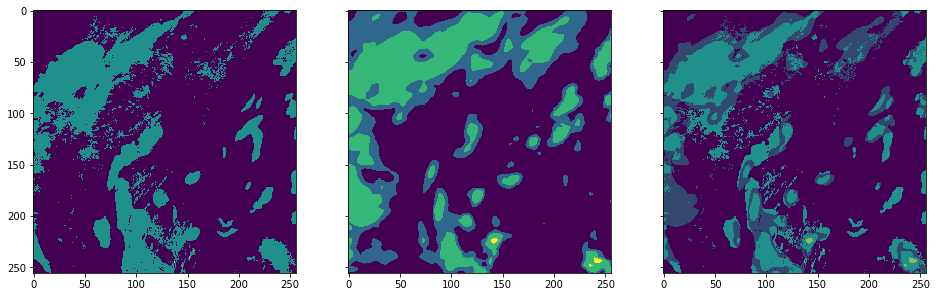

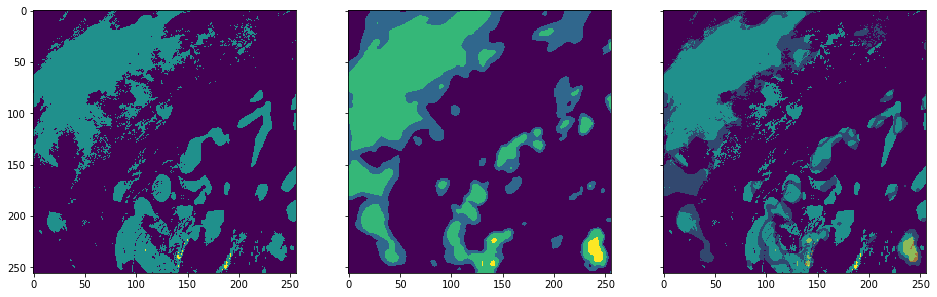

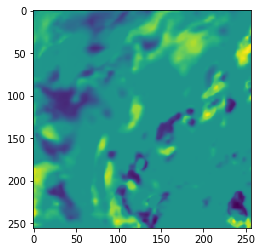

'for image in range(input_images_rgb.shape[0]):\n    for channel in range(input_images_rgb.shape[1]):\n        plt.imshow(input_images_rgb[image][channel])\n        plt.show()\nplt.imshow(input_images_rgb[0][0]-input_images_rgb[0][-1])\nplt.show()'

In [10]:
#### prediction

import math

model.eval()   # Set model to evaluate mode

test_dataset = SimDataset(1, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)
        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()

print(pred.shape)
print(pred.max(), pred.min())
print(np.unique(pred))



masks = (np.rint(np.array(labels.cpu())*3)*255/3).astype('int')
#masks = (np.array(labels.cpu())*255).astype('int')

prediction = (np.rint(np.array((pred*3)))*255/3).astype('int')
#prediction = (np.array(pred)*255).astype('int')
prediction_masked = np.ma.masked_where(prediction == 0, prediction)
print(np.unique(masks))
print(np.unique(prediction))
print(np.array(labels.cpu()).shape)
for image in range(pred.shape[0]):
    for channel in range(pred.shape[1]):
        f, plot = plt.subplots(1, 3, sharex='all', sharey='all', figsize=(16, 48))
        plot[0].imshow(masks[image][channel])
        plot[1].imshow(prediction[image][channel])
        plot[2].imshow(masks[image][channel])
        plot[2].imshow(prediction_masked[image][channel], alpha=.5)
        #plt.imshow(pred[image][channel])
        #plt.imshow(masks[image][channel])
        plt.show()
plt.imshow(pred[0][0]-pred[0][-1])
plt.show()



"""masks = (np.rint(np.array(labels.cpu())*255)).astype('int')
for image in range(masks.shape[0]):
    for channel in range(masks.shape[1]):
        plt.imshow(masks[image][channel])
        plt.show()
plt.imshow(masks[0][0]-masks[0][-1])
plt.show()"""

# Change channel-order and make 3 channels for matplot
#input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]
input_images_rgb = np.array(inputs.cpu())

"""for image in range(input_images_rgb.shape[0]):
    for channel in range(input_images_rgb.shape[1]):
        plt.imshow(input_images_rgb[image][channel])
        plt.show()
plt.imshow(input_images_rgb[0][0]-input_images_rgb[0][-1])
plt.show()"""

# Map each channel (i.e. class) to each color
#print(np.unique(np.array(target_masks_rgb[0])))
#print(np.array((labels[0])))

#target_masks_rgb = [helper.masks_to_colorimg(x) for x in np.ceil(labels.cpu().numpy()*4.0)]
#pred_rgb = [helper.masks_to_colorimg(x) for x in np.floor(pred*4.0)]

# target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()*3.0]
# pred_rgb = [helper.masks_to_colorimg(x) for x in pred*3.0]



# print(labels.cpu().numpy()[0][0][0][0], pred[0][0][0][0])
# print(target_masks_rgb[0][0][0], pred_rgb[0][0][0])

#helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [11]:
# torch.save(model, "/home/ubuntuos/WeatherUNet/pytorch_unet_1000:1000_trained_60_channels_(3, 3)")
#model = torch.load("/home/ubuntuos/WeatherUNet/pytorch_unet_3000_trained_30_channels")